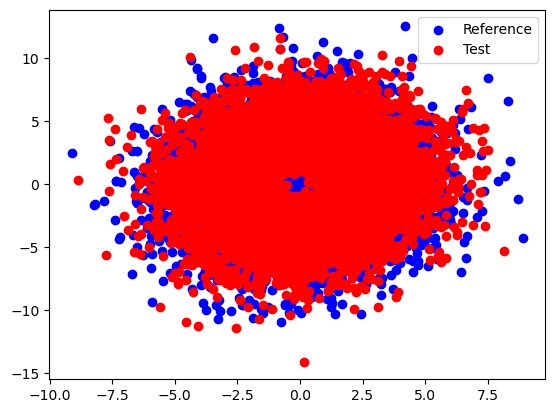

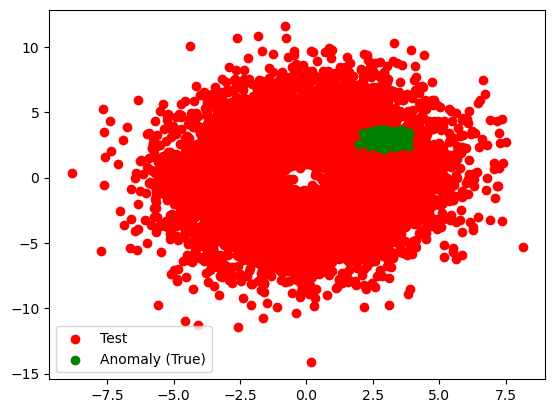

In [75]:
import numpy as np
import sys
sys.path.append("../../eagleeye")
import EagleEye,From_data_to_binary
import matplotlib.pyplot as plt

"""
# We have included a function to calculate all relevant statisitcs for a given binary sequence, as well as helper functions to genenrate the binares if you don't have them already.
# All that is reuqired is a reference set, test set and range of kstar values. 
"""

####################################################################################
# Make the data sets
# 2D Gaussian reference set with test set that has the same distribution plus an additional gaussian anomaly at [3,3]
num_ref           = 10000
reference_samples = np.random.multivariate_normal([0,0], [[5,0.5],[0.5,10]], num_ref)

anom_injection    = 300
anom_subtraction  = 700
bkg_injection     = num_ref+anom_subtraction-anom_injection

test_samples      = np.random.multivariate_normal([0,0], [[5,0.5],[0.5,10]], bkg_injection)

# Remove anom_subtraction points within a circle of radius 1 centered at (0,0)
# Calculate the distance of each point from the center (0,0)
distance_from_center = np.linalg.norm(test_samples, axis=1)
# Identify points within the circle of radius 1
points_within_circle = np.where(distance_from_center <= 1)[0]
# Randomly select 'anom_subtraction' points from these identified points

points_to_remove = np.random.choice(points_within_circle, anom_subtraction, replace=False)

# Remove the selected points from the test samples
test_samples     = np.delete(test_samples, points_to_remove, axis=0)

# Inject anom_injection points at [3,3]
anom_samples      = np.random.multivariate_normal([3,3], [[0.1,0],[0,0.1]], anom_injection)

labels            = np.zeros(len(test_samples))

test_samples      = np.vstack((test_samples, anom_samples))
labels            = np.append(labels, np.ones(anom_injection))



# Plot the data
plt.scatter(reference_samples[:,0], reference_samples[:,1], c='b', label='Reference')
plt.scatter(test_samples[:,0], test_samples[:,1], c='r', label='Test')
plt.legend()
plt.show()

plt.scatter(test_samples[:,0], test_samples[:,1], c='r', label='Test')
plt.scatter(anom_samples[:,0], anom_samples[:,1], c='g', label='Anomaly (True)')
plt.legend()
plt.show()



In [76]:
####################################################################################
# Begin calls to EagleEye
validation                                     = num_ref        # Number of samples to use for validation 
# validation                                     = None        # Number of samples to use for validation 
Kmax                                           = 500            # Maximum value of kstar to consider
kstar_range                                    = range(20, Kmax) # Range of kstar values to consider
binary_sequences                               = From_data_to_binary.create_binary_array_cdist(test_samples, reference_samples, num_neighbors=Kmax, num_cores=100, validation=validation,partition_size=100,verbose=True)
stats                                          = EagleEye.calculate_p_values(binary_sequences, kstar_range=kstar_range, validation=validation,num_cores=10,verbose=True)
# Extract the test and validation statistics!
Upsilon_i, kstar_, Upsilon_i_Val, kstar_Val    = stats['Upsilon_i'],stats['kstar_'],stats['Upsilon_i_Val'],stats['kstar_Val']


Validation size is:  10000
Processing partition 17/150
Processing partition 25/150
Processing partition 31/150
Processing partition 5/150
Processing partition 13/150
Processing partition 12/150
Processing partition 8/150
Processing partition 2/150
Processing partition 3/150
Processing partition 1/150
Processing partition 6/150
Processing partition 14/150
Processing partition 4/150
Processing partition 15/150
Processing partition 7/150
Processing partition 9/150
Processing partition 11/150
Processing partition 10/150
Processing partition 60/150
Processing partition 16/150
Processing partition 21/150
Processing partition 18/150
Processing partition 20/150
Processing partition 19/150
Processing partition 29/150
Processing partition 42/150
Processing partition 23/150
Processing partition 22/150
Processing partition 32/150
Processing partition 41/150
Processing partition 28/150
Processing partition 26/150
Processing partition 37/150
Processing partition 24/150
Processing partition 40/150
Pr

Can we immediately see anomalimes manifesting with discrete kstar/Upsilon?


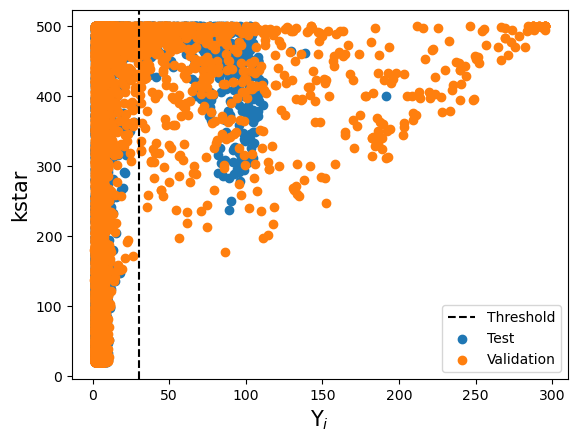

Number of points that pass upsilon threshold:  484.0
Number of background points that pass threshold =  196
Number of estimted false_positives =  677
False positive rate (Estimate):  0.0677
False Positive Rate (True):  0.4049586776859504
Number of  True positives  (Estimate):  451.2332
Number of  True positives  (True):  288
True Positive Rate  (True):  0.5950413223140496


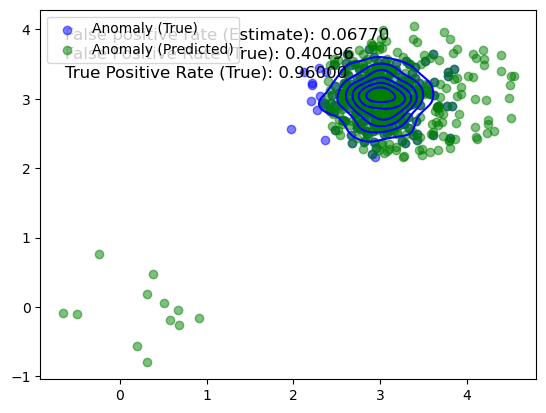

In [77]:
from scipy.stats import gaussian_kde

# ... and plot!
print("Can we immediately see anomalimes manifesting with discrete kstar/Upsilon?")

upsilon_star = 30 # Choose a threshold
plt.axvline(upsilon_star, color='k', linestyle='--',label='Threshold')
plt.scatter(Upsilon_i, kstar_, label='Test')
plt.scatter(Upsilon_i_Val,kstar_Val, label='Validation')
plt.xlabel(r'$\Upsilon_i$', fontsize=15)
plt.ylabel('kstar',fontsize=15)
plt.legend()
plt.show()

# Now we can use the threshold to classify the anomalies
anomaly_indices = np.where(Upsilon_i > upsilon_star)[0]
anomalies       = test_samples[anomaly_indices]
plt.scatter(anom_samples[:,0], anom_samples[:,1], c='b', label='Anomaly (True)',    alpha=0.5)
plt.scatter(anomalies[:,0], anomalies[:,1], c='g', label='Anomaly (Predicted)',alpha=0.5)


# Calculate the point density in feature space
kde = gaussian_kde(anom_samples.T)
x, y = np.mgrid[anom_samples[:,0].min():anom_samples[:,0].max():100j, anom_samples[:,1].min():anom_samples[:,1].max():100j]
positions = np.vstack([x.ravel(), y.ravel()])
density = np.reshape(kde(positions).T, x.shape)

false_positives = Upsilon_i_Val[Upsilon_i_Val > upsilon_star]
fpr             = len(false_positives) / len(Upsilon_i_Val)
N_gtr_th        = float(sum(Upsilon_i>upsilon_star))

print("Number of points that pass upsilon threshold: ", N_gtr_th)
print("Number of background points that pass threshold = ",  sum((Upsilon_i>upsilon_star)[labels==0]) )
print("Number of estimted false_positives = ", len(false_positives))
print("False positive rate (Estimate): ", fpr  )
print('False Positive Rate (True): ',     sum((Upsilon_i>upsilon_star)[labels==0]) / sum(Upsilon_i>upsilon_star) )
print("Number of  True positives  (Estimate): ", (N_gtr_th - N_gtr_th * fpr))   # Can't estimate the TPR since we have no info about number of initial anomalies
print("Number of  True positives  (True): ",  sum((Upsilon_i>upsilon_star)[labels==1]))        
print('True Positive Rate  (True): ' ,     sum((Upsilon_i>upsilon_star)[labels==1]) / sum(Upsilon_i>upsilon_star) ) 
# 
# Add text annotations for the false positive and true positive rates
plt.text(0.05, 0.95, f"False positive rate (Estimate): {len(false_positives) / len(Upsilon_i_Val):.5f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f"False Positive Rate (True): {sum((Upsilon_i>upsilon_star)[labels==0]) / sum(Upsilon_i>upsilon_star):.5f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.85, f"True Positive Rate (True): {sum((Upsilon_i > upsilon_star)[labels == 1]) / len(labels[labels == 1]):.5f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')


# Plot the density contours
plt.contour(x, y, density, colors='b')
plt.legend()
plt.show()

# Print the true and false positive rates
false_positives    = Upsilon_i_Val[Upsilon_i_Val>upsilon_star]


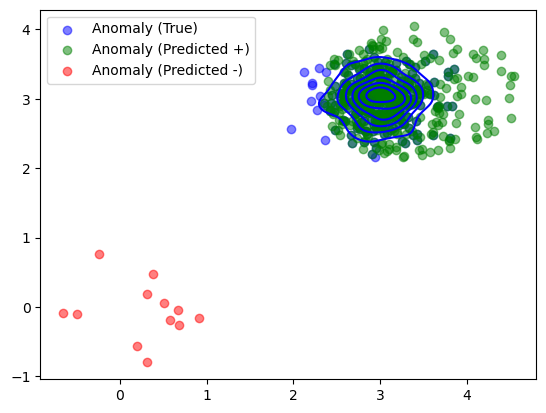

In [78]:
# Calculate over and under deensity points in test wrt reference

Upsilon_i_plus, Upsilon_i_minus ,kstar_plus,kstar_minus= stats['Upsilon_i_plus'], stats['Upsilon_i_minus'] ,stats['kstar_plus'],stats['kstar_minus']

# Now we can use the threshold to classify the anomalies
anomaly_indices_plus = np.where(Upsilon_i_plus > upsilon_star)[0]
anomalies_plus = test_samples[anomaly_indices_plus]
anomaly_indices_minus = np.where(Upsilon_i_minus > upsilon_star)[0]
anomalies_minus = test_samples[anomaly_indices_minus]

plt.scatter(anom_samples[:, 0], anom_samples[:, 1], c='b', label='Anomaly (True)', alpha=0.5)
plt.scatter(anomalies_plus[:, 0], anomalies_plus[:, 1], c='g', label='Anomaly (Predicted +)', alpha=0.5)
plt.scatter(anomalies_minus[:, 0], anomalies_minus[:, 1], c='r', label='Anomaly (Predicted -)', alpha=0.5)

kde = gaussian_kde(anom_samples.T)
x, y = np.mgrid[anom_samples[:,0].min():anom_samples[:,0].max():100j, anom_samples[:,1].min():anom_samples[:,1].max():100j]
positions = np.vstack([x.ravel(), y.ravel()])
density = np.reshape(kde(positions).T, x.shape)


# Plot the density contours
plt.contour(x, y, density, colors='b')
plt.legend()
plt.show()

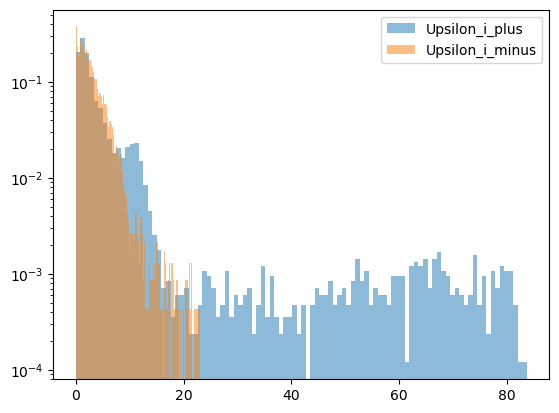

In [72]:
h=plt.hist(Upsilon_i_plus, bins=100, alpha=0.5, label='Upsilon_i_plus',density=True)
h=plt.hist(Upsilon_i_minus, bins=100, alpha=0.5, label='Upsilon_i_minus',density=True)
plt.yscale('log')
plt.legend()

# Gif

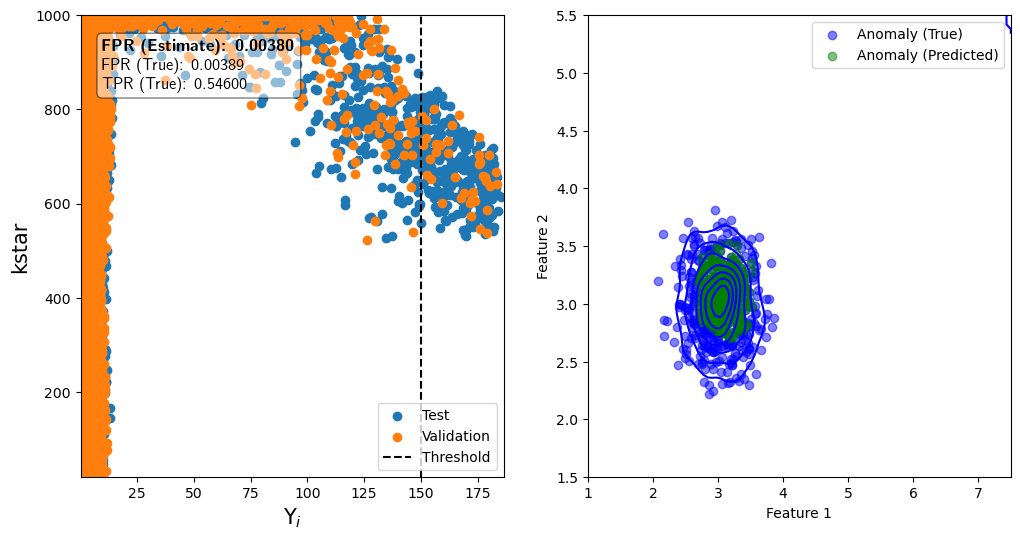

In [ ]:
# Make a gif!
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import gaussian_kde

# Create figure and axes for side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Define the range of upsilon_star values
upsilon_star_values = np.linspace(5, 150,30)  # From 5 to 30 inclusive

# --- Set axis limits and aspects outside the animate function ---
# For ax1 (First Plot)
x_min_ax1 = min(Upsilon_i.min(), Upsilon_i_Val.min()) - 1
x_max_ax1 = max(Upsilon_i.max(), Upsilon_i_Val.max()) + 1
y_min_ax1 = min(min(kstar_), min(kstar_Val)) - 1
y_max_ax1 = max(max(kstar_), max(kstar_Val)) + 1

ax1.set_xlim(x_min_ax1, x_max_ax1)
ax1.set_ylim(y_min_ax1, y_max_ax1)
ax1.set_xlabel(r'$\Upsilon_i$', fontsize=15)
ax1.set_ylabel('kstar', fontsize=15)


# For ax2 (Second Plot)
x_min_ax2 = 1
x_max_ax2 = 7.5
y_min_ax2 = 1.5
y_max_ax2 = 5.5

ax2.set_xlim(x_min_ax2, x_max_ax2)
ax2.set_ylim(y_min_ax2, y_max_ax2)


# Set aspect ratios if desired (e.g., equal or 'auto')
ax1.set_aspect('auto')
ax2.set_aspect('auto')

# Prepare static elements of the plots
# First Plot Legends
test_scatter = ax1.scatter(Upsilon_i, kstar_, label='Test', color='C0')
val_scatter = ax1.scatter(Upsilon_i_Val, kstar_Val, label='Validation', color='C1')
threshold_line, = ax1.plot([], [], 'k--', label='Threshold')
ax1.legend(loc='lower right')

# Second Plot Legends
anom_true_scatter = ax2.scatter([], [], c='b', label='Anomaly (True)', alpha=0.5)
anom_pred_scatter = ax2.scatter([], [], c='g', label='Anomaly (Predicted)', alpha=0.5)
ax2.legend()

def animate(i):
    # Current upsilon_star value
    upsilon_star = upsilon_star_values[i]

    # --- First Plot ---
    # Update the threshold line
    threshold_line.set_data([upsilon_star, upsilon_star], [y_min_ax1, y_max_ax1])

    # Update the title to reflect current upsilon_star

    # --- Second Plot ---
    # Clear previous scatters but keep axis limits and labels
    for coll in ax2.collections:
        coll.remove()
    for contour in ax2.collections:
        contour.remove()

    # Classify anomalies based on current threshold
    anomaly_indices = np.where(Upsilon_i > upsilon_star)[0]
    anomalies = test_samples[anomaly_indices]

    # Plot anomalies
    ax2.scatter(anom_samples[:, 0], anom_samples[:, 1], c='b', label='Anomaly (True)', alpha=0.5)
    ax2.scatter(anomalies[:, 0], anomalies[:, 1], c='g', label='Anomaly (Predicted)', alpha=0.5)
    ax2.set_xlabel('Feature 1')
    ax2.set_ylabel('Feature 2')
    # Calculate the point density using KDE
    kde = gaussian_kde(anom_samples.T)
    x, y = np.mgrid[x_min_ax2:x_max_ax2:100j, y_min_ax2:y_max_ax2:100j]
    positions = np.vstack([x.ravel(), y.ravel()])
    density = np.reshape(kde(positions).T, x.shape)

    # Plot the density contours
    ax2.contour(x, y, density, colors='b')

    # Update the title


    # --- Calculate and Display Rates ---
    false_positives = Upsilon_i_Val[Upsilon_i_Val > upsilon_star]
    fpr_estimate = len(false_positives) / len(Upsilon_i_Val)
    fpr_true = sum((Upsilon_i > upsilon_star)[labels == 0]) / len(labels[labels == 0])
    tpr_true = sum((Upsilon_i > upsilon_star)[labels == 1]) / len(labels[labels == 1])

    # Remove previous text box if it exists
    if hasattr(animate, 'text_box'):
        animate.text_box.remove()

    # Display rates on the first plot
    # Display rates on the first plot
    textstr = '\n'.join((
        r'\textbf{FPR (Estimate): ' + f'{fpr_estimate:.5f}' + '}',
        f'FPR (True): {fpr_true:.5f}',
        f'TPR (True): {tpr_true:.5f}'))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    animate.text_box = ax1.text(
        0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=props, usetex=True  # Enable LaTeX
    )

# Create animation object
ani = animation.FuncAnimation(fig, animate, frames=len(upsilon_star_values), interval=200, repeat=True)

# Save the animation as a GIF
ani.save('example1.gif', writer='pillow', fps=5)

# Display the animation
plt.show()
